**Notebook to perform hierarchical clustering on D1K1 and D1K2 linker backbones.**

In [1]:
import json
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

Select input json file with RMSD calculations between pairs of RFdiffusion models:

In [2]:
input_file = "RMSD_D1K1.json"
basename = os.path.basename(os.path.splitext(input_file)[0])

In [3]:
with open(input_file) as file:
    rmsd_data = json.load(file)

In [4]:
rmsd_data.keys()

dict_keys(['rmsd', 'n_atoms'])

# Convert the rmsd dictionary to a matrix

Get the name of all RFdiffusion models in order:

In [5]:
names = list(rmsd_data['rmsd'].keys())
for i in rmsd_data['rmsd'].keys():
    names.extend(rmsd_data['rmsd'][i].keys())

names = np.sort(np.unique(names))
print(f"{names[:3]}...")
print(f"Total number of models: ", len(names))

['D1K1_20-60_516_20_4' 'D1K1_20-60_516_20_42' 'D1K1_20-60_516_20_47']...
Total number of models:  66


Convert the rmsd dictionary into a distance matrix:

In [6]:
rmsd_matrix = np.zeros((len(names), len(names)))
for i, str1 in enumerate(names):
    for j, str2 in enumerate(names[i+1:]):
        rmsd_matrix[i, i+j+1] = rmsd_matrix[i+j+1, i] = rmsd_data['rmsd'][str1][str2]
rmsd_matrix

array([[0.        , 0.28735679, 0.21507573, ..., 3.74277544, 4.56711388,
        4.08182335],
       [0.28735679, 0.        , 0.32700983, ..., 3.8285749 , 4.68190718,
        4.19376183],
       [0.21507573, 0.32700983, 0.        , ..., 3.66548347, 4.48746872,
        4.00959587],
       ...,
       [3.74277544, 3.8285749 , 3.66548347, ..., 0.        , 2.42922735,
        1.495754  ],
       [4.56711388, 4.68190718, 4.48746872, ..., 2.42922735, 0.        ,
        1.53810155],
       [4.08182335, 4.19376183, 4.00959587, ..., 1.495754  , 1.53810155,
        0.        ]])

Check that the matrix is symmetric:

In [7]:
np.all(np.abs(rmsd_matrix-rmsd_matrix.T) < 1e-8)

True

# Functions

Function to select a linker prototype for each cluster.
For each cluster, it loops through all its linkers and calculates the distance to all other linkers in the cluster.
The linker that minimizes this distance is selected as the prototype for the cluster.

In [8]:
def prototypes_bydistance(rmsd_matrix, y_ag):
    clusters = np.unique(y_ag)
    prototipes = []
    for cl in clusters:
        linkers = np.where(y_ag == cl)[0]
        dist_to_rest = [sum(rmsd_matrix[i][j] for j in linkers) for i in linkers]
        prototipes.append(linkers[np.argmin(dist_to_rest)])
    return prototipes

# Agglomerative clustering

## Average linkage

Select RMSD threshold for clustering and name of the output file:

In [9]:
threshold = 1.5 #RMSD threshold
output_file = f"{basename}_agglomerative_th{threshold:.1f}.json"
output_file

'RMSD_D1K1_agglomerative_th1.5.json'

Perform Sklearn AgglomerativeClustering with the precomputed distance matrix and average linkage:

In [10]:
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(distance_threshold=threshold, metric='precomputed', linkage='average', 
                             compute_distances=True, n_clusters=None)
y_ag = ac.fit_predict(rmsd_matrix)
y_ag

array([ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4, 10,  4,  4,
        3,  3,  3,  3,  3,  8,  3,  3,  8,  3,  8,  7,  3,  5,  3,  8,  5,
        3,  5,  5,  3,  3,  5,  3,  5,  3,  2,  5,  3,  2,  2,  2,  2, 11,
       11,  1,  1,  9,  0,  0,  0,  1,  1,  1,  0,  1,  1,  6,  0])

# Show a dendrogram

Function to plot a dendrogram representing the hierarchical clustering.

Adapted from professors Valeriano Méndez and Carlos García-Gutiérrez.

In [11]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import set_link_color_palette

def plot_dendrogram(model, title, plotSize, color_palette=None, **kwargs):
    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    
    # Plot the corresponding dendrogram
    fig, ax = plt.subplots(1, 1, figsize=plotSize)  # set size
    fig.suptitle(title)

    # Set color palette:
    if color_palette is not None:
        set_link_color_palette(color_palette)
    else:
        set_link_color_palette(['b', 'g', 'r', 'c', 'm', 'y'])
    # If the color of above threshold branches has not been set it is added.
    if 'above_threshold_color' not in kwargs.keys():  
        kwargs['above_threshold_color'] = 'k'
    dendrogram(linkage_matrix, **kwargs)
     
    plt.tick_params(axis='x', bottom='off', top='off', labelbottom='off')
    plt.tight_layout()
    
    ### We add the threshold line
    w_c = kwargs['above_threshold_color']
    w_y = kwargs['color_threshold']
    if w_y > 0:
        xmin, xmax, ymin, ymax = plt.axis()
        plt.plot([w_y for n in range(int(xmax-xmin))], c=w_c, ls='--', linewidth=2)
        
    return fig

Shorten model names to display in the dendrogram. We take only the linker number:

In [12]:
shortened_names = []
for name in names:
    splitted = name.split('_')
    shortened_names.append(f'{splitted[-1]}')

Plot the dendrogram:

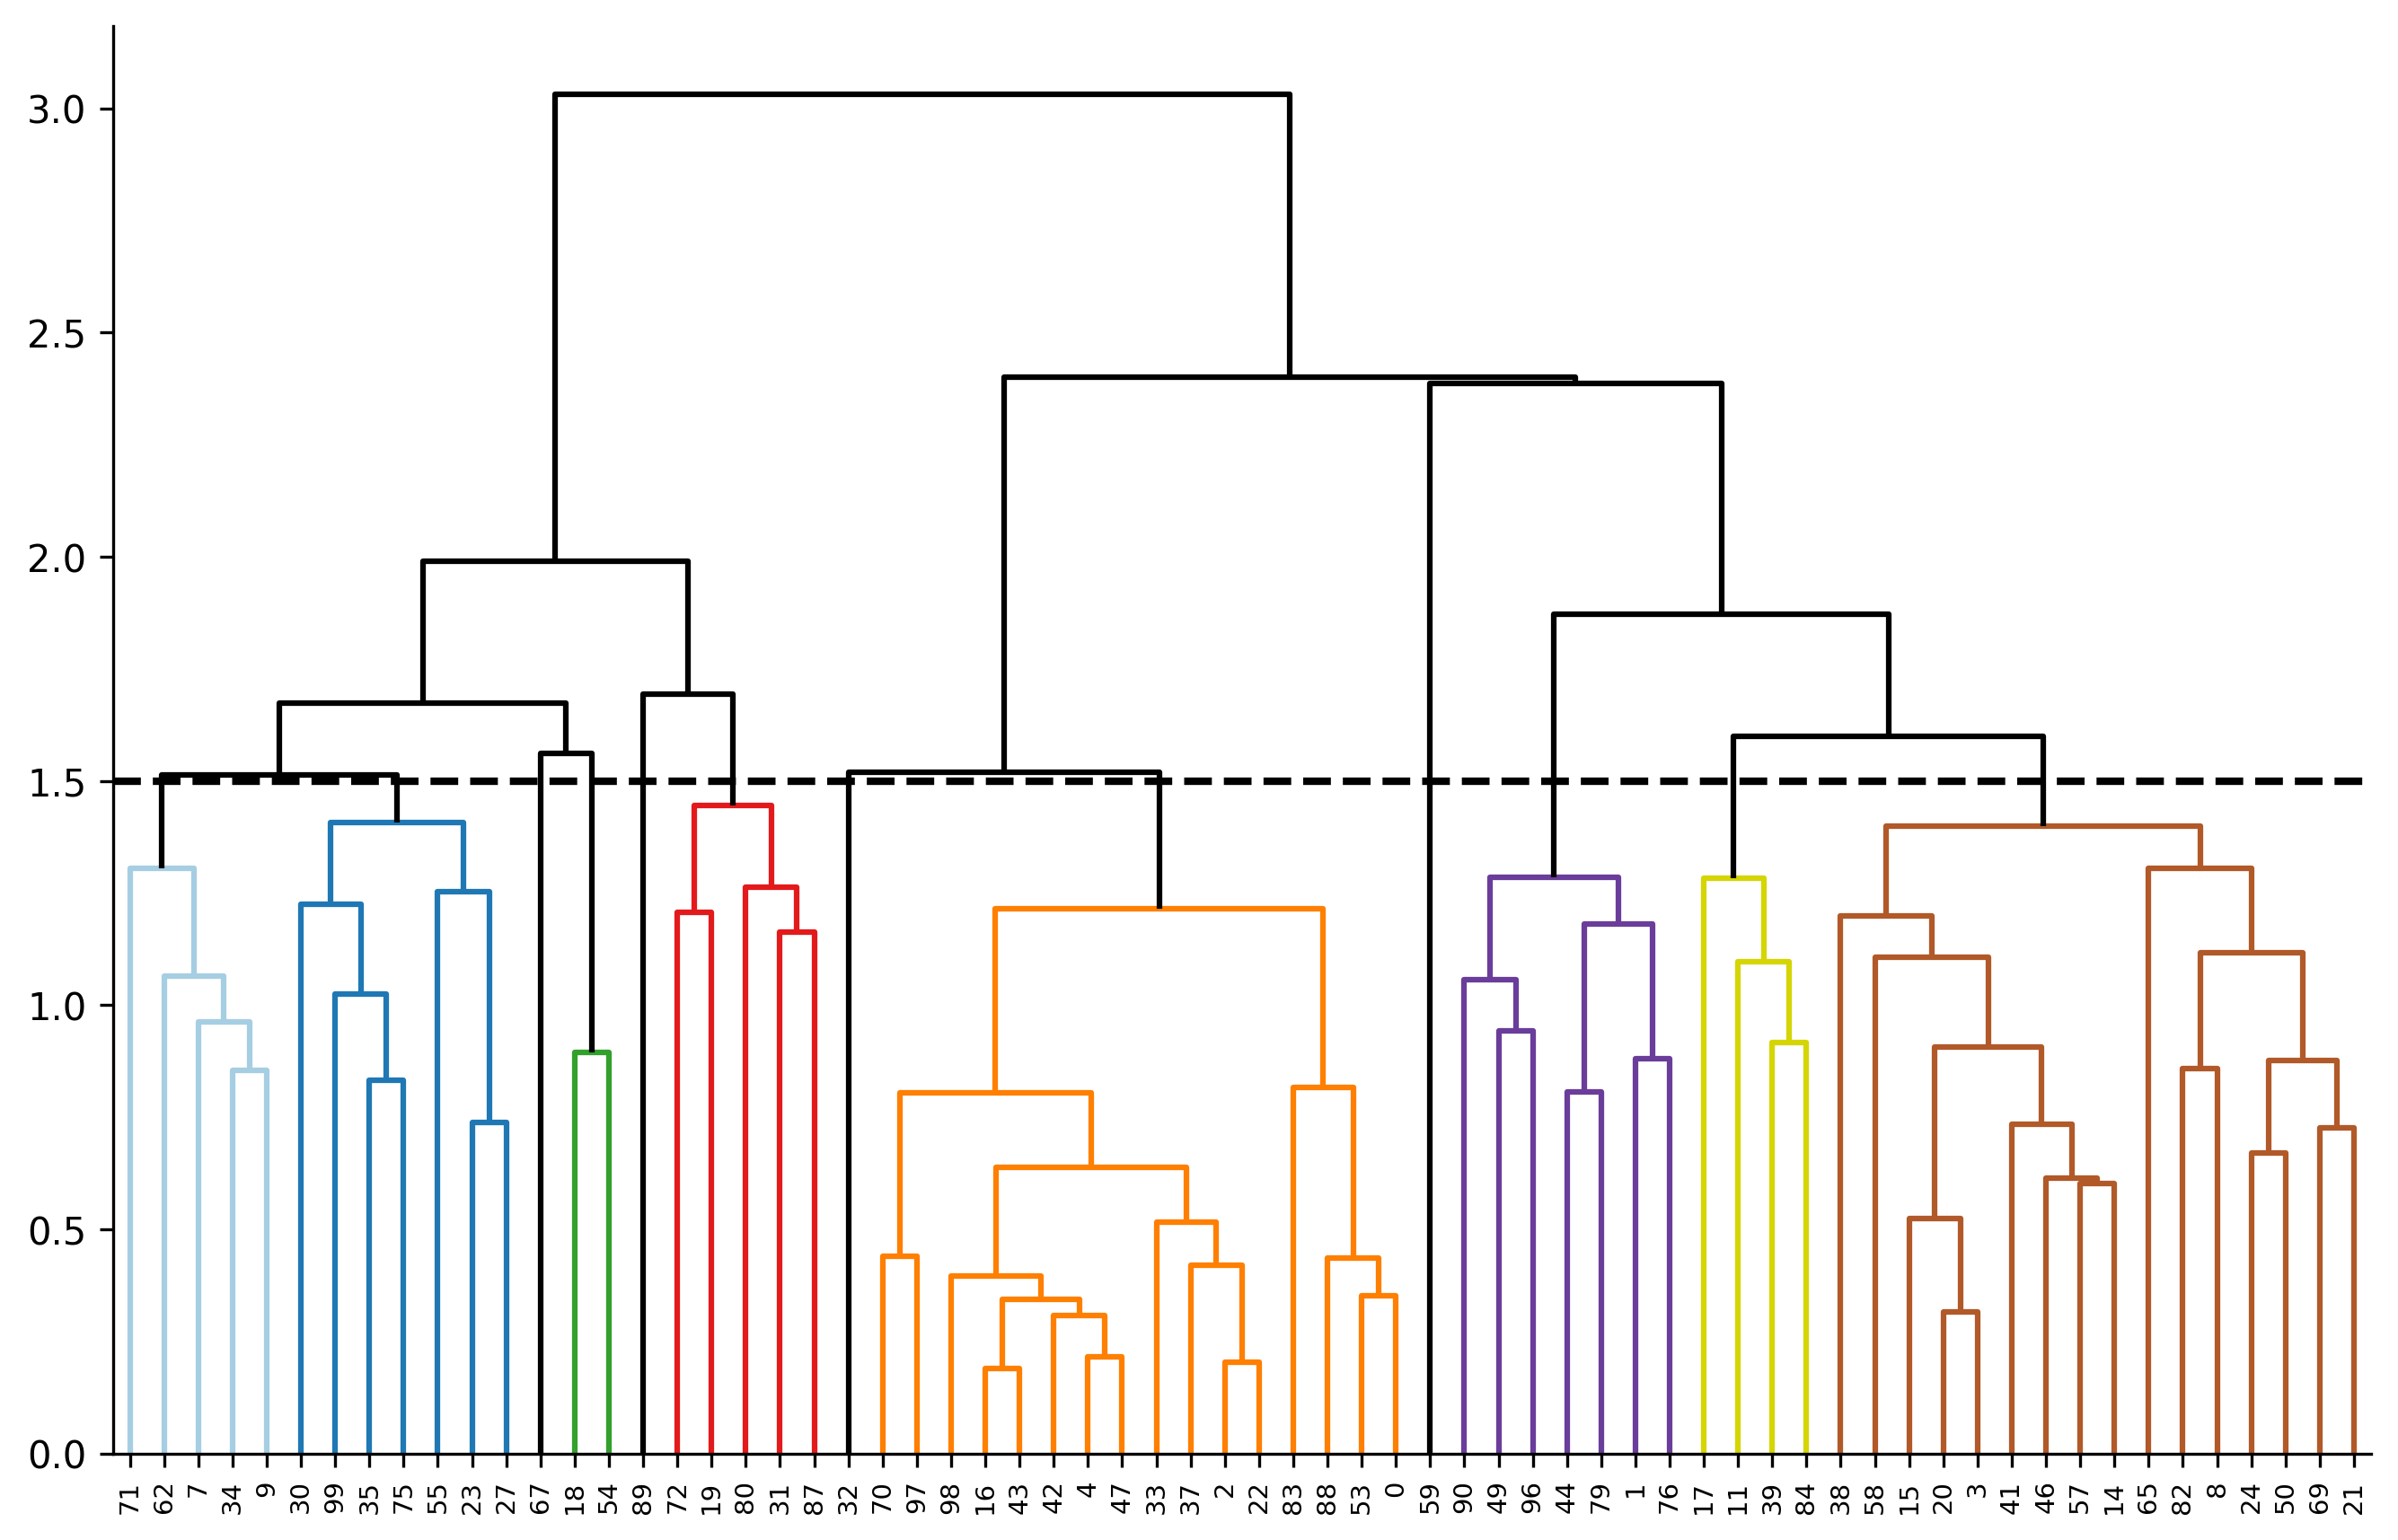

In [13]:
palette = ['#a6cee3', '#1f78b4', '#33a02c', '#e31a1c', 
            '#ff7f00', '#6a3d9a', '#d5d503', '#b15928']
fig = plot_dendrogram(ac, None, (9, 6), truncate_mode=None, color_palette=palette, labels=shortened_names, 
                      color_threshold=threshold)
plt.xticks(fontsize=7)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='x', top=False)
plt.show()

### Select prototipes:

Select by minimimum distance to all other members of the cluster:

In [14]:
prototypes = prototypes_bydistance(rmsd_matrix, y_ag)
prototypes

[55, 53, 48, 29, 8, 35, 64, 28, 27, 54, 14, 50]

Check what prototypes have been selected:

In [15]:
names[prototypes]

array(['D1K1_20-60_516_47_31', 'D1K1_20-60_516_46_35',
       'D1K1_20-60_516_42_9', 'D1K1_20-60_516_34_41',
       'D1K1_20-60_516_22_22', 'D1K1_20-60_516_36_49',
       'D1K1_20-60_516_54_89', 'D1K1_20-60_516_33_59',
       'D1K1_20-60_516_33_39', 'D1K1_20-60_516_46_67',
       'D1K1_20-60_516_26_32', 'D1K1_20-60_516_45_18'], dtype='<U20')

Write an output file containing:
- A list with all the RFdiffusion model names
- A list with the corresponding cluster to each model
- A list with the selected prototypes

In [17]:
data = [names.tolist(), y_ag.tolist(), names[prototypes].tolist()]

with open(output_file, "w") as file:
    json.dump(data, file, indent=4)